# Intensity Calculation Testbed
Notebook for testing all calculations needed for intensity calculation in fiasco.

In [1]:
import os
os.environ['XUVTOP'] = '/Users/willbarnes/ssw/packages/chianti/dbase/'

import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve,Gaussian1DKernel,Box1DKernel,Model1DKernel
import astropy.modeling
import fiasco
import plasmapy.atomic
import hissw
import ChiantiPy.core as ch
import ChiantiPy.tools.filters as ch_filters

%matplotlib inline

/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


 using cli
 using CLI for selections


/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/ChiantiPy-0.7.dev697-py3.6.egg/ChiantiPy/core/IpyMspectrum.py:9: UserWarning: ipyparallel not found. You won't be able to use the ipymspectrum module
  warnings.warn("ipyparallel not found. You won't be able to use the ipymspectrum module")


In [1184]:
foo = fiasco.Element('iron', temperature=np.logspace(5,8,500)*u.K)

In [1185]:
ioneq = foo.equilibrium_ionization()

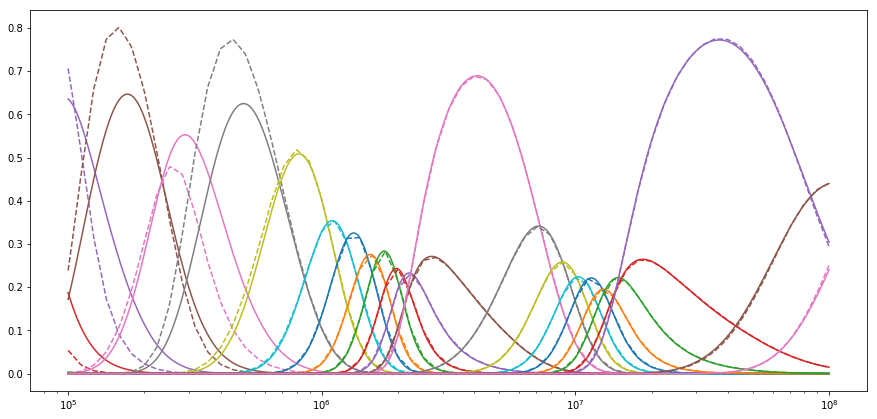

In [1186]:
plt.figure(figsize=(15,7))
for i in foo:
    plt.plot(foo.temperature,ioneq[:,i.charge_state],color=f'C{i.charge_state%10}',ls='-')
    plt.plot(i.temperature,i.ioneq,color=f'C{i.charge_state%10}',ls='--')
plt.xscale('log')

In [1189]:
foo[11].temperature[np.argmax(foo[11].ioneq)]

<Quantity 1571783.71777316 K>

## Proton-to-electron ratio

In [4]:
temperature = np.logspace(3,10,100)*u.K

In [3]:
pe_ratio = fiasco.proton_electron_ratio(temperature, ioneq_filename='chianti',
                                        abundance_filename='sun_coronal_1992_feldman')

/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/fiasco-0.1.dev197-py3.6.egg/fiasco/fiasco.py:55: UserWarning: Not including B. Abundance not available.
  warnings.warn(f'Not including {el.atomic_symbol}. Abundance not available.')
/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/fiasco-0.1.dev197-py3.6.egg/fiasco/fiasco.py:55: UserWarning: Not including Be. Abundance not available.
  warnings.warn(f'Not including {el.atomic_symbol}. Abundance not available.')
/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/fiasco-0.1.dev197-py3.6.egg/fiasco/fiasco.py:55: UserWarning: Not including Cl. Abundance not available.
  warnings.warn(f'Not including {el.atomic_symbol}. Abundance not available.')
/Users/willbarnes/anaconda/envs/fiasco/lib/python3.6/site-packages/fiasco-0.1.dev197-py3.6.egg/fiasco/fiasco.py:55: UserWarning: Not including Co. Abundance not available.
  warnings.warn(f'Not including {el.atomic_symbol}. Abundance not available.

In [ ]:
chianti_idl = hissw.ScriptMaker(ssw_packages=['chianti'], ssw_paths=['chianti'])

In [ ]:
chianti_script = """
temperature = {{temperature}}
!abund_file = '/Users/willbarnes/ssw/packages/chianti/dbase/abundance/sun_coronal_1992_feldman.abund'
!ioneq_file = '/Users/willbarnes/ssw/packages/chianti/dbase/ioneq/chianti.ioneq'
pe_ratio=proton_dens(temperature)
"""
chianti_results = chianti_idl.run(chianti_script,
                                  args={'temperature': np.log10(temperature.value).tolist()},
                                  save_vars=['pe_ratio'], verbose=False)

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax2 = ax.twinx()
ax.plot(temperature, pe_ratio)
ax.plot(temperature, chianti_results['pe_ratio'],'o',color='C1',ls='',markevery=3)
ax2.plot(temperature, (pe_ratio - chianti_results['pe_ratio'])/chianti_results['pe_ratio'],color='C2')
ax.axhline(y=0.83,ls=':',color='k')
ax.set_xscale('log')
ax2.set_yscale('symlog',linthreshy=1e-6)
ax2.set_ylim(-1,1)
ax.set_ylim(0.81,1.01)

## Collision Strengths ($\Upsilon$)

In [2]:
test_ion = fiasco.Ion('H 1', [1e6,1e7]*u.K)#np.logspace(4,8,20)*u.K)

In [ ]:
test_ion._ioneq[test_ion._dset_names['ioneq_filename']]['temperature']

In [ ]:
#test_ion_chiantipy = ch.ion('fe_16', temperature=test_ion.temperature.value, eDensity=np.array([1e8,1e9]))

In [ ]:
energy_ratio = np.outer(const.k_B.cgs*test_ion.temperature,
                        1.0/test_ion._scups['delta_energy'].to(u.erg))

In [ ]:
#%%timeit -n 1 -r 1
upsilon = test_ion.effective_collision_strength()

In [ ]:
upsilon.shape

In [ ]:
type(test_ion._scups['bt_upsilon']) != np.dtype('O')

In [ ]:
type(test_ion._scups['bt_upsilon'])

In [ ]:
type(np.dtype('O'))

In [ ]:
plt.plot(test_ion.transitions.upper_level,'o')
plt.plot(test_ion.transitions.upper_level[~test_ion.transitions.is_twophoton],'.')
#plt.xlim(2500,3000)

In [ ]:
chianti_idl = hissw.ScriptMaker(ssw_packages=['chianti'], ssw_paths=['chianti'])
chianti_script = """
temperature = {{temperature}}
filename=!xuvtop+'/{{element_name}}/{{ion_name}}/{{ion_name}}.scups'
print,filename
read_scups, filename,splstr
descale_scups, temperature, splstr, {{index}}, upsilon
"""
upsilon_idl = np.zeros(upsilon[:,::].shape)
for i,index in enumerate(np.arange(upsilon.shape[1])[::]):
    chianti_results = chianti_idl.run(
        chianti_script,
        args={'temperature': test_ion.temperature.value.tolist(),
              'index': index,
              'ion_name': '_'.join(test_ion.ion_name.lower().split()),
              'element_name': test_ion.atomic_symbol.lower(),},                 
        save_vars=['upsilon'], verbose=False)
    upsilon_idl[:,i] = chianti_results['upsilon']

In [ ]:
plt.figure(figsize=(12,8))
for i,index in enumerate(np.arange(upsilon.shape[1])[::10]):
    plt.plot(test_ion.temperature, upsilon[:,index],color=f'C{i%10}',ls='-');
    plt.plot(test_ion.temperature, upsilon_vec[:,index],color=f'C{i%10}', ls='--');
    plt.plot(test_ion.temperature, upsilon_idl[:,index], marker='o',ls='',markevery=5,color=f'C{i%10}');
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$T$ [K]')
plt.ylabel(r'$\Upsilon$')

## Excitation and De-excitation Rates
Test funcs for computing excitation and de-excitation rates due to collisions

In [ ]:
ex_rate = test_ion.electron_collision_excitation_rate()

In [ ]:
ex_rate.shape

In [ ]:
plt.plot(test_ion.temperature, ex_rate[:,::10000]);
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-20,1e-9)

In [ ]:
dex_rate = test_ion.electron_collision_deexcitation_rate()

In [ ]:
plt.plot(test_ion.temperature, dex_rate[:,::10000]);
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-16,1e-8)

In [ ]:
ex_rate_p = test_ion.proton_collision_excitation_rate()

In [ ]:
dex_rate_p = test_ion.proton_collision_deexcitation_rate()

In [ ]:
plt.plot(test_ion.temperature, ex_rate_p,)
plt.plot(test_ion.temperature, dex_rate_p)
plt.xscale('log')
plt.yscale('log')

## Emissivity and Level Populations

Need to compare the level populations in fiasco with those computed in CHIANTI IDL.

In the IDL code, the `calc_emiss.pro` function calculates the quantity,

$$
\epsilon_{ij}  = \frac{hc}{\lambda_{ij}} A_{ij} N_j,\quad[\text{erg}\,\text{cm}^{-3}]
$$

for each transition $ij$. 

In [3]:
density = [1e8,1e9,1e10]/(u.cm**3)

In [ ]:
level_pops = test_ion.level_populations(density)

In [ ]:
contrib_func = test_ion.contribution_function(density)

In [ ]:
emiss_calc_script = """
temp = {{temperature}}
dens = {{density}}
emiss = emiss_calc({{Z}},{{stage}},temp=temp,dens=dens)
"""

In [ ]:
emiss_idl = chianti_idl.run(emiss_calc_script,
                            args={'temperature': np.log10(test_ion.temperature.value).tolist(),
                                  'density': np.log10(density.value).tolist(), 
                                  'Z': test_ion.atomic_number, 'stage': test_ion.ionization_stage},
                            save_vars=['emiss'],)

In [ ]:
wvl = np.fabs(test_ion.transitions.wavelength[~test_ion.transitions.is_twophoton])

In [ ]:
contrib_func_sort = contrib_func[:,:,wvl.argsort()]

In [ ]:
emiss_idl_mat = np.zeros(contrib_func.shape)
for i,a in enumerate(emiss_idl['emiss']['em']):
    emiss_idl_mat[:,:,i] = a.T

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.pcolormesh(emiss_idl_mat[0,:,:],
               norm=matplotlib.colors.SymLogNorm(1e-100,vmin=1e-30,vmax=1e-10))
plt.subplot(212)
plt.pcolormesh(contrib_func_sort[0,:,:].value,
               norm=matplotlib.colors.SymLogNorm(1e-100,vmin=1e-30,vmax=1e-10))

In [ ]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.fabs(emiss_idl_mat[1,:,:] - contrib_func_sort[1,:,:].value)/emiss_idl_mat[1,:,:],
               #norm=matplotlib.colors.SymLogNorm(1e-100,vmin=1e-30,vmax=1e-10)
               norm=matplotlib.colors.SymLogNorm(1e-200,vmin=1e-3,vmax=1)
              )
plt.colorbar()

In [ ]:
test_ion.ioneq

In [ ]:
p2e = fiasco.proton_electron_ratio(test_ion.temperature, **test_ion._dset_names)

In [ ]:
ph_energy = ((const.h * const.c)/wvl).to(u.erg)

In [ ]:
np.outer(np.outer(p2e * test_ion.ioneq, 1/density),
         (ph_energy * test_ion.transitions.A[~test_ion.transitions.is_twophoton])[np.newaxis,np.newaxis,:]).shape

In [ ]:
(ph_energy * test_ion.transitions.A[~test_ion.transitions.is_twophoton])[np.newaxis,np.newaxis,:].shape

In [ ]:
foo = (np.outer(p2e * test_ion.ioneq, 1/density)[:,:,np.newaxis] * contrib_func) * 1/density.unit

In [ ]:
foo * (density**2)[np.newaxis,:,np.newaxis]

## Intensity and Spectra

In [10]:
intens = test_ion.intensity(density, u.Quantity([1e27],'cm^-5')) / 0.83

Get corresponding wavelengths

In [11]:
wvl = test_ion.transitions.wavelength[~test_ion.transitions.is_twophoton]

In [12]:
wvl_range = (900*u.angstrom, 1300*u.angstrom)

In [13]:
i_wvl = np.where(np.logical_and(wvl >= wvl_range[0], wvl<=wvl_range[1]))

Hack a "filter"

**Option 1:** Use Astropy filters (preferable)

In [14]:
#wavelength_kernel = np.arange(wvl_range[0].value, wvl_range[1].value, 0.01)
#wavelength_kernel = np.hstack([wavelength_kernel, wvl[i_wvl].value])
#wavelength_kernel = np.sort(np.unique(wavelength_kernel)) * wvl.unit
#intensity_kernel = np.zeros(intens.shape[:2]+wavelength_kernel.shape)
#intensity_kernel[:,:,fiasco.util.vectorize_where(wavelength_kernel.value, wvl[i_wvl].value)] = intens[:,:,i_wvl[0]]

In [15]:
bin_width = 0.1*u.angstrom
num_bins = int(((wvl_range[1] - wvl_range[0])/bin_width).value)

In [16]:
intensity_kernel,wavelength_kernel = np.histogram(wvl[i_wvl].value, bins=num_bins, range=(wvl_range[0].value, wvl_range[1].value), weights=intens[0,-1,i_wvl[0]].value,)
wavelength_kernel = (wavelength_kernel[1:] + wavelength_kernel[:-1])/2.

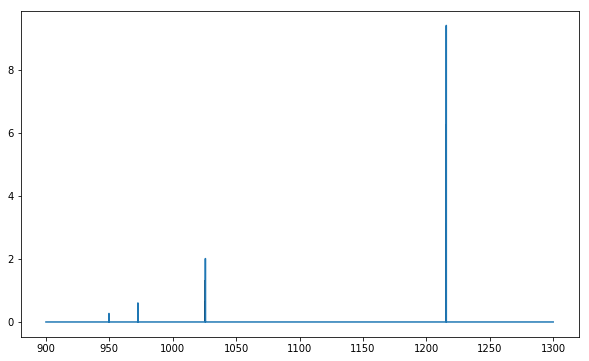

In [17]:
plt.figure(figsize=(10,6))
plt.step(wavelength_kernel,intensity_kernel,where='mid')
plt.vlines(wvl[i_wvl].value, 0., intens[0,-1,i_wvl].value,color='k')
#plt.xlim(1020,1030)
#plt.ylim(0,3)

In [18]:
fwhm = 0.5*u.angstrom
std = (fwhm/(2.*np.sqrt(2*np.log(2))))
#kernel = Gaussian1DKernel((std.value/bin_width).value)
gamma = 0.1
kernel_size = int(2000*gamma/np.sqrt(2.*np.log(2.)))
kernel_size = kernel_size + 1 if kernel_size%2==0 else kernel_size
kernel  = Model1DKernel(
    astropy.modeling.models.Lorentz1D(
        amplitude=1./np.pi/gamma,
        x_0=0.,
        fwhm=2.*gamma/bin_width.value,
    ),
    x_size=kernel_size)
kernel = Model1DKernel(
    astropy.modeling.models.Gaussian1D(
        amplitude=1/np.sqrt(2.*np.pi)/std.value,
        mean=0.,
        stddev=(std/bin_width).value
    ),
    x_size=int(8*(std/bin_width).value) +1 if int(8*(std/bin_width).value)%2==0 else int(8.*(std/bin_width).value)
)

In [19]:
std

<Quantity 0.21233045 Angstrom>

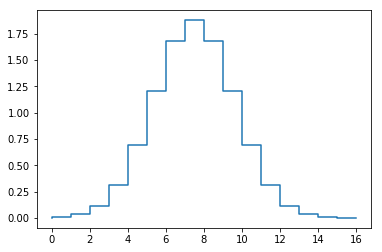

In [1148]:
plt.plot(kernel,drawstyle='steps')

In [1155]:
test_ion.ioneq

<Quantity [2.652e-07, 1.998e-08]>

In [1149]:
smooth_intensity_kernel = convolve(intensity_kernel,
                                   kernel,
                                   normalize_kernel=False,
                                  )

**Option 2:** By hand (not preferable, but easier in some ways)

In [1150]:
wavelength_hand = np.arange(wvl_range[0].value, wvl_range[1].value, 0.01) * wvl.unit

In [1151]:
smooth_intensity_hand = np.zeros(wavelength_hand.shape)
for i in i_wvl[0]:
    smooth_intensity_hand += (intens[0,-1,i ].value / (np.sqrt(2.*np.pi)*std.value) 
                              * np.exp(-((wavelength_hand.value - wvl[i].value)**2)/(2*std.value**2)))

In [1152]:
ch_ion = ch.ion('h_1', temperature=test_ion.temperature.value,eDensity=1e10,em=1e27,abundance='sun_photospheric_1998_grevesse')

In [1153]:
wavelength_ch = np.arange(900,1300,bin_width.value) 
ch_ion.spectrum(wavelength_ch,filter=(ch_filters.gaussian,std.value),)

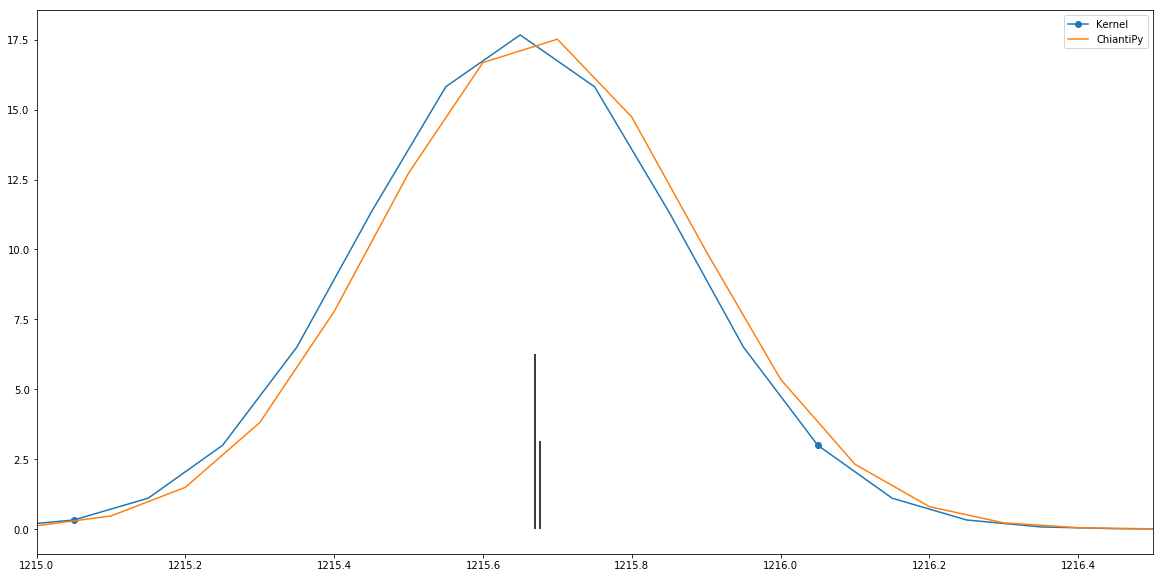

In [1191]:
fig = plt.figure(figsize=(20,10))
#for i,index in enumerate(i_wvl[0]):
ax = fig.gca()#fig.add_subplot(3,3,i+1)
#ax.plot(wavelength_hand, smooth_intensity_hand, label='Hand')
ax.plot(wavelength_kernel, smooth_intensity_kernel, label='Kernel', marker='o',markevery=10)
ax.plot(wavelength_ch,ch_ion.Spectrum['intensity'][0,:],label='ChiantiPy')
ax.vlines(wvl[i_wvl].value, 0., intens[0,-1,i_wvl].value,color='k')
#ax.set_xlim(wvl[index].value-1,wvl[index].value+1)
#ax.set_ylim(0,intens[0,-1,index].value)
#for w,i in zip(wvl,intens[0,-1,:]):
#    plt.plot([w.value,w.value],[0,i.value],'C1')
#plt.plot(wavelength, intens[0,-1,:])
plt.xlim(1215.,1216.5);
#plt.ylim(1e-2,5)
#plt.yscale('log')
#plt.ylim(1e-6,4);
plt.legend()

In [56]:
bin_width=0.01*u.angstrom
fwhm = 0.75*u.angstrom
std = (fwhm/(2.*np.sqrt(2*np.log(2))))
kernel = Model1DKernel(
    astropy.modeling.models.Gaussian1D(
        amplitude=1/np.sqrt(2.*np.pi)/std.value,
        mean=0.,
        stddev=(std/bin_width).value
    ),
    x_size=int(8*(std/bin_width).value) +1 if int(8*(std/bin_width).value)%2==0 else int(8.*(std/bin_width).value)
)

In [57]:
wave, spec = test_ion.spectrum(density, u.Quantity([1e27],'cm^-5'), wavelength_range=u.Quantity([900,1300],'angstrom'),
                               bin_width=bin_width, kernel=kernel)

(0, 10)

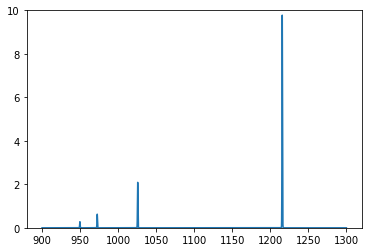

In [58]:
plt.plot(wave, spec[0,2,:])
#plt.xlim(1214.5,1217)
#plt.xlim(1025,1027)
plt.ylim(0,10)

In [70]:
foo = np.array([])#np.random.rand(2,4,10)#u.Quantity(np.array([]))
bar = np.random.rand(2)#u.Quantity(np.array([1,2]))
np.concatenate((foo,bar),).shape

(2,)

## Radiative Loss Rates
The radiative loss is given by,

$$
E_R = n_en_H^2\Lambda(T_e)\quad [\text{erg}\,\text{cm}^{-3}\,\text{s}^{-1}]
$$

where $\Lambda(T_e)$ describes how the plasma radiates away energy at different temperatures. According to Eqs. 42-44 of [BR13](http://adsabs.harvard.edu/abs/2013SSRv..178..271B), it is given by,

$$
\Lambda = \sum_X\Lambda_X = \sum_X\sum_k\Lambda_{X,k} = \sum_X\sum_k\sum_i\Lambda_{X,k,i}\quad [\text{erg}\,\text{cm}^{3}\,\text{s}^{-1}]
$$

where $X$ indexes the element, $k$ the ion, and $i$ the particular transition in that ion. The radiative loss for a particular transition, again according to BR13, is

In [ ]:
temperature = np.logspace(4,9,100)*u.K

In [ ]:
el = fiasco.Element('iron', temperature)

In [4]:
density = [1e10]/(u.cm**3)

In [ ]:
rad_loss_iron = el.radiative_loss(density)

In [3]:
c = fiasco.IonCollection(*[fiasco.Element(el, np.logspace(4,9,200)*u.K) for el in fiasco.list_elements()])

In [ ]:
rl = c.radiative_loss(density)

In [ ]:
collection = None
for el in fiasco.list_elements():
    if collection is None:
        collection = fiasco.Element(el, temperature)
    else:
        collection += fiasco.Element(el, temperature)

In [ ]:
rad_loss = collection.radiative_loss(density)

In [ ]:
rad_loss_multi_ion = (fiasco.Ion('Fe 12',temperature,abundance_filename='sun_coronal_1992_feldman') 
                      + fiasco.Element('O',temperature,abundance_filename='sun_coronal_1992_feldman') 
                      + fiasco.Element('Ca',temperature,abundance_filename='sun_coronal_1992_feldman') 
                      + fiasco.Ion('Fe 16',temperature,abundance_filename='sun_coronal_1992_feldman')).radiative_loss(density)

In [ ]:
idl_rad_loss_script = """
density = {{density}}
bb_rad_loss,temperature,loss_rate,density=density,/no_setup
"""

In [ ]:
rad_loss_results = chianti_idl.run(idl_rad_loss_script, args={'density': density.value[0]}, save_vars=['temperature','loss_rate'])

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(temperature, rad_loss_iron[:,0],label='iron only')
plt.plot(temperature, rad_loss_no_iron[:,0],label='All')
plt.plot(rad_loss_results['temperature'], 0.83*rad_loss_results['loss_rate'],label='IDL',
         #marker='o',markersize=10,
         ls='--')
plt.xlabel(r'$T$ [MK]',fontsize=20)
plt.ylabel(f'$\Lambda$ [{rad_loss.unit.to_string(format="latex")}]',fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-26,1e-21)
plt.xlim(1e4,1e9)
plt.legend()